# Mapping results Nath & Thingbaijam (2012)


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [21]:
import os
import sys
from glob import glob

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

import numpy as np
import pandas as pd

from openquake.hazardlib import imt

from toolbox import logspace, stdval, annotate, read_hazard_csv

In [3]:
map_imts = ['PGA','SA(0.2)','SA(1.0)']
map_tables = ['India_pga.csv','India_psa_pt2sec.csv','India_psa_1sec.csv']
model_path = '../Data/nath2012probabilistic'
map_table_list = [os.path.join(model_path, item) for item in map_tables]
map_table_df_list = [pd.read_csv(file_name) for file_name in map_table_list]

In [4]:
df_map = map_table_df_list[0][['lon', 'lat']]
map_csv = 'NT2012_Figure_7_Indian_subcontinent_lon_lat.csv'
print('sites_csv = %s' % map_csv)
df_map.to_csv(map_csv, header=False, index=False, float_format='%g')

sites_csv = NT2012_Figure_7_Indian_subcontinent_lon_lat.csv


In [5]:
poes_nom = np.array([0.1, 0.02])
T_nom = 50  # years
rate = -np.log(1 - poes_nom)/T_nom  # per year
T_inv = 1.  # year
poes_inv = 1 - np.exp(-rate*T_inv)
poe_labels = ['%g%% in %g years' % (100*poe, T_nom) for poe in poes_nom]

print('investigation_time = %s' % str(T_inv))
print('poes = %s' % ' '.join(['%.5g' % poe for poe in poes_inv]))
print(poe_labels)

investigation_time = 1.0
poes = 0.002105 0.00040397
['10% in 50 years', '2% in 50 years']


In [6]:
imts = [imt.from_string(item) for item in ['PGA', 'SA(0.2)', 'SA(1.0)']]
im_levels = logspace(0.004, 5, 6)

print('intensity_measure_types_and_levels = {%s}' 
      % ', '.join(['"%s": [%s]' % (str(im_type), ', '.join([str(iml) for iml in im_levels])) 
                   for im_type in imts]))

intensity_measure_types_and_levels = {"PGA": [0.0047, 0.0068, 0.01, 0.015, 0.022, 0.033, 0.047, 0.068, 0.1, 0.15, 0.22, 0.33, 0.47, 0.68, 1.0, 1.5, 2.2, 3.3, 4.7], "SA(0.2)": [0.0047, 0.0068, 0.01, 0.015, 0.022, 0.033, 0.047, 0.068, 0.1, 0.15, 0.22, 0.33, 0.47, 0.68, 1.0, 1.5, 2.2, 3.3, 4.7], "SA(1.0)": [0.0047, 0.0068, 0.01, 0.015, 0.022, 0.033, 0.047, 0.068, 0.1, 0.15, 0.22, 0.33, 0.47, 0.68, 1.0, 1.5, 2.2, 3.3, 4.7]}


In [7]:
# areal_only_no_fmd_uncertainty_map
n_gmpe_lt_rlzs = 3*3*2*2*3*2*3*3*2
print('n_gmpe_lt_rlzs = %d' % n_gmpe_lt_rlzs)
n_src_lt_rlzs = 2
print('n_src_lt_rlzs = %d' % n_src_lt_rlzs)
n_lt_rlzs = n_gmpe_lt_rlzs*n_src_lt_rlzs
print('n_lt_rlzs = %d' % n_lt_rlzs)
n_sites = len(df_map)
print('n_sites = %d' % n_sites)
n_imt_iml = len(imts)*len(im_levels)
print('n_imt_iml = %dx%d = %d' % (len(imts),len(im_levels),n_imt_iml))
n_curves = n_lt_rlzs*n_sites*n_imt_iml
print('n_curves = n_lt_rlzs*n_sites*n_imt_iml = %d*%d*%d = %d' %
     (n_lt_rlzs, n_sites, n_imt_iml, n_curves))
n_files = n_lt_rlzs*n_imt_iml
print('n_files = n_lt_rlzs*n_imt_iml = %d*%d = %d' %
     (n_lt_rlzs, n_imt_iml, n_files))

n_gmpe_lt_rlzs = 3888
n_src_lt_rlzs = 2
n_lt_rlzs = 7776
n_sites = 8102
n_imt_iml = 3x19 = 57
n_curves = n_lt_rlzs*n_sites*n_imt_iml = 7776*8102*57 = 3591065664
n_files = n_lt_rlzs*n_imt_iml = 7776*57 = 443232


## Post-Processing

In [15]:
plot_cities = np.array([['Bangalore', 'Bhuj', 'Chennai'],
                        ['Guwahati', 'Jabalpur', 'Kolkata'],
                        ['Koyna', 'Mumbai', 'New Delhi']])
df_cities = pd.read_csv('../Data/nath2012probabilistic/Table 3.csv', skiprows=1, index_col='City')
df_cities = df_cities[df_cities.index.isin(plot_cities.flatten())]
df_cities

,Latitude (°N),Longitude (°E),BIS,zone,GSHAP,Present,Other,Reference
City,,,,,,,,
Bangalore,12.98,77.58,0.05,II,0.05,0.11,0.10; 0.15,Jaiswal and Sinha 2007†; Anbazhagan et al. 2009
Bhuj,23.25,69.66,0.18,V,0.20,0.42,0.25; 0.20-0.70,Jaiswal and Sinha 2007†; Petersen et al. 2004‡
Chennai,13.00,80.18,0.08,III,0.05,0.12,0.089; 0.10,Menon et al. 2010; Jaiswal and Sinha 2007†
Guwahati,26.18,91.73,0.18,V,0.30,0.66,0.50,Sharma and Malik 2006
Jabalpur,23.20,79.95,0.08,III,0.10,0.19,0.15,Jaiswal and Sinha 2007†
Kolkata,22.65,88.45,0.08,III,0.10,0.15,0.10,Jaiswal and Sinha 2007†
Koyna,17.40,73.75,0.12,IV,0.25,0.47,0.25,Jaiswal and Sinha 2007†
Mumbai,19.11,72.85,0.08,III,0.10,0.16,0.15,Jaiswal and Sinha 2007†
New Delhi,28.56,77.11,0.12,IV,0.15,0.24,NaN,NaN


hazard: mean
investigation_time: 1 year
IMTs: PGA, SA(0.2), SA(1.0)
POEs: 0.002105, 0.00040397
POEs in 50 years: 10%, 1.99999%
IML limits: 0.005 g, 2 g
Grid step: 0.2°
Saving: hazard_map-mean_18441.pdf


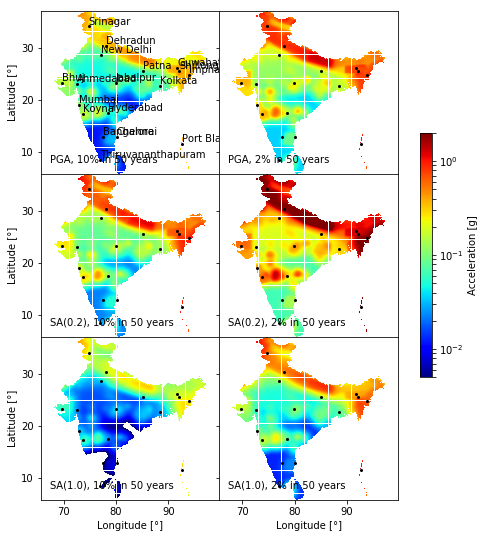

In [57]:
map_csv = './map_collapsed_v1/hazard_map-mean_18441.csv'
df_calc = pd.read_csv(map_csv, header=1, index_col=['lon', 'lat'])
with open(map_csv) as file:
    hazard_type, inv_time = file.readline().split(',')
hazard_type = hazard_type.split()[1]
assert inv_time.split('=')[0].strip() == 'investigation_time'
T_inv = float(inv_time.split('=')[1])
print('hazard: ' + hazard_type)
print('investigation_time: %g year' % T_inv)

imts, poes = zip(*[item.split('-') for item in df_calc.columns])
imts = sorted(set(imts))
poes = np.array([float(item) for item in sorted(set(poes), reverse=True)])
print('IMTs: %s' % ', '.join(imts))
print('POEs: %s' % ', '.join(str(item) for item in poes))

T_nom = 50  # years
rate = -np.log(1 - poes)/T_inv
poes_nom = 1 - np.exp(-rate*T_nom)
poe_labels = ['%g%% in %g years' % (100*poe, T_nom) for poe in poes_nom]
print('POEs in %g years: %s' % (T_nom, ', '.join('%g%%' % (100*poe) for poe in poes_nom)))

limits = (df_calc[df_calc != 0].min().min(), df_calc.max().max())
limits = stdval(limits, 3)
print('IML limits: ' + ', '.join('%g g' % item for item in limits))

grid_step = np.mean(np.diff(sorted(list(set(df_calc.index.get_level_values('lat'))))))
print('Grid step: %g°' % grid_step)

point_size = (grid_step/0.2)**2
fig, axes = plt.subplots(len(imts), len(poes), 
                         figsize=(4*len(poes),3*len(imts)), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'datalim', 'aspect': 1})
fig.subplots_adjust(hspace=0, wspace=0)
for imt, row_axes in zip(imts, axes):
    for poe, poe_nom, ax in zip(poes, poes_nom, row_axes):
        
        imt_poe_label = ('%s, %.3g%% in %g years' % 
                         (str(imt), 100*poe_nom, T_nom))
        annotate(imt_poe_label, 'lower left', ax)
        
        im = ax.scatter(df_calc.index.get_level_values('lon'), 
                         df_calc.index.get_level_values('lat'), 
                         c=df_calc[imt + '-' + str(poe)].values, 
                         s=point_size, marker='s', edgecolor='none', cmap='jet', 
                         norm=LogNorm(limits[0], limits[1]))

        ax.plot(df_cities['Longitude (°E)'], 
                df_cities['Latitude (°N)'], 
                'ko', markersize=2)
        
for city, info in df_cities.iterrows():
    axes[0, 0].annotate(city, (info['Longitude (°E)'], info['Latitude (°N)']), va='bottom')

axes[0, 0].set_aspect('equal')
axes[0, 0].autoscale(enable=True, axis=u'both', tight=True)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, label='Acceleration [g]')
        
[ax.set_xlabel(u'Longitude [°]') for ax in axes[-1, :]]
[ax.xaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[-1, :]]
[ax.set_ylabel(u'Latitude [°]') for ax in axes[:, 0]]
[ax.yaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[:, 0]]
map_pdf = os.path.splitext(os.path.basename(map_csv))[0] + '.pdf'
print('Saving: ' + map_pdf)
fig.savefig(map_pdf, dpi=300, bbox_inches='tight')

In [40]:
df_cities.loc['Koyna']

Latitude (°N)                        17.4
Longitude (°E)                      73.75
BIS                                  0.12
zone                                   IV
GSHAP                                0.25
Present                              0.47
Other                                0.25
Reference         Jaiswal and Sinha 2007†
Name: Koyna, dtype: object

In [36]:
df_calc.loc[(73.8, 17.4)]

PGA-0.002105          0.167963
PGA-0.00040397        0.369457
SA(0.2)-0.002105      0.288116
SA(0.2)-0.00040397    0.644791
SA(1.0)-0.002105      0.060231
SA(1.0)-0.00040397    0.161112
Name: (73.8, 17.4), dtype: float64

In [41]:
df_pub.loc[(73.8, 17.4)]

PGA-0.002105          0.903085
PGA-0.00040397        0.468019
SA(0.2)-0.002105      1.406005
SA(0.2)-0.00040397    0.695446
SA(1.0)-0.002105      0.395087
SA(1.0)-0.00040397    0.156144
Name: (73.8, 17.4), dtype: float64

In [42]:
df_ratio.loc[(73.8, 17.4)]

PGA-0.002105          0.500092
PGA-0.00040397        1.843479
SA(0.2)-0.002105      0.456597
SA(0.2)-0.00040397    1.780946
SA(1.0)-0.002105      0.325070
SA(1.0)-0.00040397    1.872625
Name: (73.8, 17.4), dtype: float64

hazard: mean
investigation_time: 1 year
IMTs: PGA, SA(0.2), SA(1.0)
POEs: 0.002105, 0.00040397
POEs in 50 years: 10%, 1.99999%
IML limits: 0.005 g, 5 g
Grid step: 0.2°
Saving: hazard_map-mean_18701.pdf


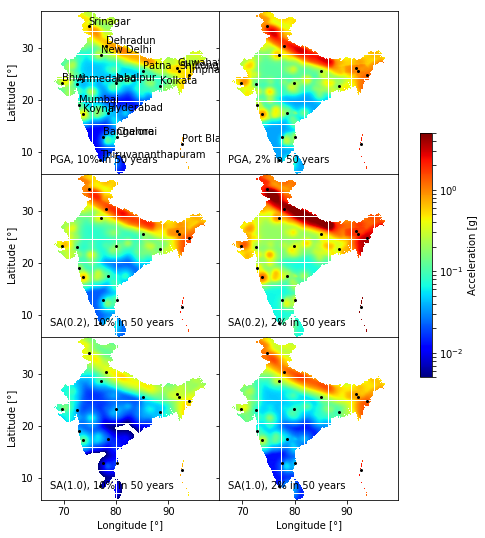

In [58]:
map_csv = './map_collapsed_v1/hazard_map-mean_18701.csv'
df_calc = pd.read_csv(map_csv, header=1, index_col=['lon', 'lat'])
with open(map_csv) as file:
    hazard_type, inv_time = file.readline().split(',')
hazard_type = hazard_type.split()[1]
assert inv_time.split('=')[0].strip() == 'investigation_time'
T_inv = float(inv_time.split('=')[1])
print('hazard: ' + hazard_type)
print('investigation_time: %g year' % T_inv)

imts, poes = zip(*[item.split('-') for item in df_calc.columns])
imts = sorted(set(imts))
poes = np.array([float(item) for item in sorted(set(poes), reverse=True)])
print('IMTs: %s' % ', '.join(imts))
print('POEs: %s' % ', '.join(str(item) for item in poes))

T_nom = 50  # years
rate = -np.log(1 - poes)/T_inv
poes_nom = 1 - np.exp(-rate*T_nom)
poe_labels = ['%g%% in %g years' % (100*poe, T_nom) for poe in poes_nom]
print('POEs in %g years: %s' % (T_nom, ', '.join('%g%%' % (100*poe) for poe in poes_nom)))

limits = (df_calc[df_calc != 0].min().min(), df_calc.max().max())
limits = stdval(limits, 3)
print('IML limits: ' + ', '.join('%g g' % item for item in limits))

grid_step = np.mean(np.diff(sorted(list(set(df_calc.index.get_level_values('lat'))))))
print('Grid step: %g°' % grid_step)

point_size = (grid_step/0.2)**2
fig, axes = plt.subplots(len(imts), len(poes), 
                         figsize=(4*len(poes),3*len(imts)), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'datalim', 'aspect': 1})
fig.subplots_adjust(hspace=0, wspace=0)
for imt, row_axes in zip(imts, axes):
    for poe, poe_nom, ax in zip(poes, poes_nom, row_axes):
        
        imt_poe_label = ('%s, %.3g%% in %g years' % 
                         (str(imt), 100*poe_nom, T_nom))
        annotate(imt_poe_label, 'lower left', ax)
        
        im = ax.scatter(df_calc.index.get_level_values('lon'), 
                         df_calc.index.get_level_values('lat'), 
                         c=df_calc[imt + '-' + str(poe)].values, 
                         s=point_size, marker='s', edgecolor='none', cmap='jet', 
                         norm=LogNorm(limits[0], limits[1]))

        ax.plot(df_cities['Longitude (°E)'], 
                df_cities['Latitude (°N)'], 
                'ko', markersize=2)
        
for city, info in df_cities.iterrows():
    axes[0, 0].annotate(city, (info['Longitude (°E)'], info['Latitude (°N)']), va='bottom')

axes[0, 0].set_aspect('equal')
axes[0, 0].autoscale(enable=True, axis=u'both', tight=True)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, label='Acceleration [g]')
        
[ax.set_xlabel(u'Longitude [°]') for ax in axes[-1, :]]
[ax.xaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[-1, :]]
[ax.set_ylabel(u'Latitude [°]') for ax in axes[:, 0]]
[ax.yaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[:, 0]]
map_pdf = os.path.splitext(os.path.basename(map_csv))[0] + '.pdf'
print('Saving: ' + map_pdf)
fig.savefig(map_pdf, dpi=300, bbox_inches='tight')

India_pga.csv renaming: {'prob2': 'PGA-0.00040397', 'prob10': 'PGA-0.002105'}
India_psa_pt2sec.csv renaming: {'prob2': 'SA(0.2)-0.00040397', 'prob10': 'SA(0.2)-0.002105'}
India_psa_1sec.csv renaming: {'prob2': 'SA(1.0)-0.00040397', 'prob10': 'SA(1.0)-0.002105'}
Saving: map_published.pdf


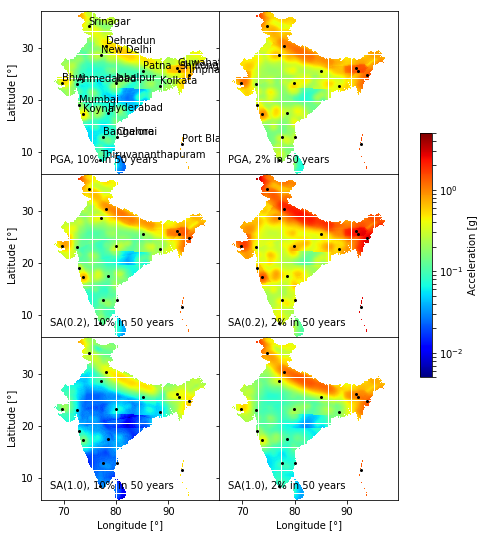

In [74]:
published_file_name = 'map_published.pdf'
model_path = '../Data/nath2012probabilistic'
map_files = ['India_pga.csv', 
             'India_psa_pt2sec.csv', 
             'India_psa_1sec.csv']
imt_rename = {'pga': 'PGA', 
              'psa_pt2sec': 'SA(0.2)', 
              'psa_1sec': 'SA(1.0)'}

dfs = []
for map_file in map_files:
    im_type = imt_rename[map_file.split('_', 1)[1].split('.')[0]]
    probs = ['prob%d' % round(100*poe_nom) for poe_nom in poes_nom]
    keys = [ '%s-%.5g' % (im_type, poe_inv) for poe_inv in poes_inv]
    rename = {prob: key for prob, key in zip(probs, keys)}
    print('%s renaming: %s' % (map_file, rename))
    df = pd.read_csv(os.path.join(model_path, map_file), index_col=['lon', 'lat'])[probs]
    df.rename(columns=rename, inplace=True)
    dfs.append(df)
df_pub = pd.concat(dfs, axis=1, sort=True)
        
fig, axes = plt.subplots(len(imts), len(poes), 
                         figsize=(4*len(poes),3*len(imts)), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'datalim', 'aspect': 1})
fig.subplots_adjust(hspace=0, wspace=0)
for imt, row_axes in zip(imts, axes):
    for poe, poe_nom, ax in zip(poes, poes_nom, row_axes):
        
        imt_poe_label = ('%s, %.3g%% in %g years' % 
                         (str(imt), 100*poe_nom, T_nom))
        annotate(imt_poe_label, 'lower left', ax)
        
        im = ax.scatter(df_pub.index.get_level_values('lon'), 
                         df_pub.index.get_level_values('lat'), 
                         c=df_pub[imt + '-' + str(poe)].values, 
                         s=point_size, marker='s', edgecolor='none', cmap='jet', 
                         norm=LogNorm(limits[0], limits[1]))
        ax.plot(df_cities['Longitude (°E)'], 
                df_cities['Latitude (°N)'], 
                'ko', markersize=2)
        
for city, info in df_cities.iterrows():
    axes[0, 0].annotate(city, (info['Longitude (°E)'], info['Latitude (°N)']), va='bottom')

plt.gca().set_aspect('equal')
plt.autoscale(enable=True, axis=u'both', tight=True)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, label='Acceleration [g]')
        
[ax.set_xlabel(u'Longitude [°]') for ax in axes[-1, :]]
[ax.xaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[-1, :]]
[ax.set_ylabel(u'Latitude [°]') for ax in axes[:, 0]]
[ax.yaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[:, 0]]
print('Saving: ' + published_file_name)
fig.savefig(published_file_name, dpi=300, bbox_inches='tight')

In [75]:
df_calc.head()

PGA-0.002105  PGA-0.00040397  SA(0.2)-0.002105  SA(0.2)-0.00040397  \
lon  lat                                                                        
68.2 23.6      0.177435        0.410245          0.294072            0.670839   
68.4 23.8      0.204802        0.465269          0.331187            0.744945   
68.6 23.4      0.174547        0.402812          0.285779            0.640367   
     23.6      0.189796        0.433480          0.308311            0.688171   
68.8 23.2      0.173994        0.405695          0.284093            0.638423   

           SA(1.0)-0.002105  SA(1.0)-0.00040397  
lon  lat                                         
68.2 23.6          0.076152            0.191028  
68.4 23.8          0.084818            0.211361  
68.6 23.4          0.077008            0.185865  
     23.6          0.081854            0.198241  
68.8 23.2          0.077097            0.185394

In [76]:
df_pub.head()

PGA-0.002105  PGA-0.00040397  SA(0.2)-0.002105  SA(0.2)-0.00040397  \
lon  lat                                                                        
68.2 23.6      0.191887        0.494498          0.305638            0.780570   
68.4 23.8      0.224177        0.571968          0.369238            0.911626   
68.6 23.4      0.220628        0.551951          0.364339            0.875989   
     23.6      0.233107        0.591483          0.387020            0.940315   
68.8 23.2      0.223542        0.561831          0.379644            0.902892   

           SA(1.0)-0.002105  SA(1.0)-0.00040397  
lon  lat                                         
68.2 23.6          0.087250            0.294353  
68.4 23.8          0.093618            0.321364  
68.6 23.4          0.098137            0.304136  
     23.6          0.098912            0.317172  
68.8 23.2          0.097512            0.306530

In [77]:
df_ratio.head()

PGA-0.002105  PGA-0.00040397  SA(0.2)-0.002105  SA(0.2)-0.00040397  \
lon  lat                                                                        
68.2 23.6      0.358819        2.137952          0.376740            2.194882   
68.4 23.8      0.358066        2.075452          0.363293            2.017521   
68.6 23.4      0.316236        1.825753          0.326236            1.757613   
     23.6      0.320881        1.859574          0.327881            1.778129   
68.8 23.2      0.309692        1.814850          0.314648            1.681636   

           SA(1.0)-0.002105  SA(1.0)-0.00040397  
lon  lat                                         
68.2 23.6          0.258711            2.189434  
68.4 23.8          0.263932            2.257693  
68.6 23.4          0.253202            1.893938  
     23.6          0.258075            2.004220  
68.8 23.2          0.251514            1.901243

Saving: map_ratio.pdf


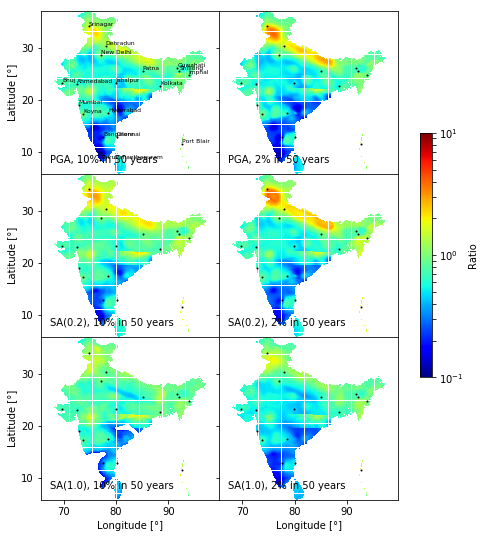

In [84]:
ratio_file_name = 'map_ratio.pdf'
df_ratio = df_calc/df_pub

fig, axes = plt.subplots(len(imts), len(poes), 
                         figsize=(4*len(poes),3*len(imts)), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'datalim', 'aspect': 1})
fig.subplots_adjust(hspace=0, wspace=0)
for imt, row_axes in zip(imts, axes):
    for poe, poe_nom, ax in zip(poes, poes_nom, row_axes):
        imt_poe_label = ('%s, %.3g%% in %g years' % 
                         (str(imt), 100*poe_nom, T_nom))
        annotate(imt_poe_label, 'lower left', ax)
        
        im = ax.scatter(df_ratio.index.get_level_values('lon'), 
                         df_ratio.index.get_level_values('lat'), 
                         c=df_ratio[imt + '-' + str(poe)].values, 
                         s=point_size, marker='s', edgecolor='none', cmap='jet', 
                         norm=LogNorm(0.1, 10))
        
        ax.plot(df_cities['Longitude (°E)'], 
                df_cities['Latitude (°N)'], 
                'ko', markersize=1)
        
for city, info in df_cities.iterrows():
    axes[0, 0].annotate(city, (info['Longitude (°E)'], 
                               info['Latitude (°N)']), 
                        va='bottom', fontsize=6)

plt.gca().set_aspect('equal')
plt.autoscale(enable=True, axis=u'both', tight=True)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, label='Ratio')
        
[ax.set_xlabel(u'Longitude [°]') for ax in axes[-1, :]]
[ax.xaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[-1, :]]
[ax.set_ylabel(u'Latitude [°]') for ax in axes[:, 0]]
[ax.yaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[:, 0]]
print('Saving: ' + ratio_file_name)
fig.savefig(ratio_file_name, dpi=300, bbox_inches='tight')